## Import Libraries

In [1]:
import nltk
import torch
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk.corpus import stopwords
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification

## Load the Pretrained Model and Tokenizer

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Custom Dataset Class

In [3]:
class EmailDataset(Dataset):
    def __init__(self, emails, labels, tokenizer, max_len):
        self.emails = emails
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.emails)

    def __getitem__(self, index):
        email = self.emails[index]
        label = self.labels[index]

        # Tokenize the input
        inputs = self.tokenizer.encode_plus(
            email,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True
        )

        return {
            'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }


## Tokenize and Prepare Data for Training

In [4]:
combined_data = pd.read_csv('data/smartsense data - merged.csv')

# Map categories to numerical labels
category_mapping = {'student': 0, 'corporate': 1, 'research': 2}

# Apply the mapping to your dataset
combined_data['Category'] = combined_data['Category'].map(category_mapping)

# Split data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(combined_data['Email'], combined_data['Category'], test_size=0.2)

# Create dataset objects
train_dataset = EmailDataset(train_texts.tolist(), train_labels.tolist(), tokenizer, max_len=64)
val_dataset = EmailDataset(val_texts.tolist(), val_labels.tolist(), tokenizer, max_len=64)

# DataLoader to batch the data
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


## Set Up Training

In [5]:
from transformers import AdamW, get_linear_schedule_with_warmup
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

# Calculate total steps for the learning rate scheduler
total_steps = len(train_loader) * 4

# Initialize the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

model.to(device)

/home/ankityadav/miniconda3/envs/env1_38/lib/python3.8/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Training Loop

/home/ankityadav/miniconda3/envs/env1_38/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/4, Train Loss: 0.4853, Val Loss: 0.2019, Val Accuracy: 0.9370
Epoch 2/4, Train Loss: 0.0778, Val Loss: 0.1589, Val Accuracy: 0.9606
Epoch 3/4, Train Loss: 0.0271, Val Loss: 0.1292, Val Accuracy: 0.9606
Epoch 4/4, Train Loss: 0.0104, Val Loss: 0.1238, Val Accuracy: 0.9449


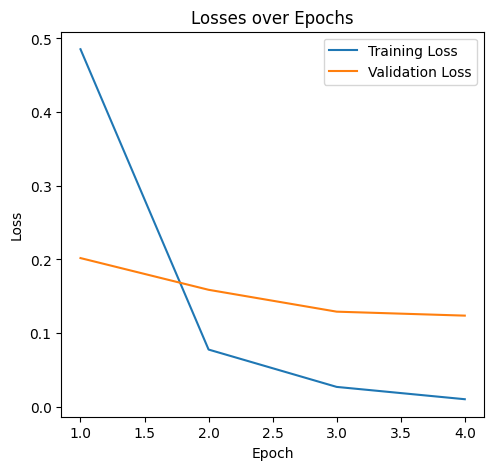

In [6]:
# Store losses and accuracies
train_losses = []
val_losses = []
val_accuracies = []

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model = model.train()
    total_loss = 0

    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    return total_loss / len(data_loader)

def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()
    total_loss = 0
    correct_preds = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct_preds += torch.sum(preds == labels)

    return total_loss / len(data_loader), correct_preds.double() / len(data_loader.dataset)

# Training the model for 4 epochs
for epoch in range(4):  
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler)
    val_loss, val_acc = eval_model(model, val_loader, loss_fn, device)

    # Append losses and accuracy to the lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/4, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

# Plotting losses and accuracies
epochs = range(1, 5)  # 4 epochs

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Losses over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()



## Model Evaluation

In [7]:
val_predictions = []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        val_predictions.extend(preds.cpu().numpy())

print(classification_report(val_labels, val_predictions, target_names=['student', 'corporate', 'research']))


              precision    recall  f1-score   support

     student       0.97      0.97      0.97        33
   corporate       0.94      0.94      0.94        51
    research       0.93      0.93      0.93        43

    accuracy                           0.94       127
   macro avg       0.95      0.95      0.95       127
weighted avg       0.94      0.94      0.94       127



## Save the Model

In [8]:
model.save_pretrained('fine-tuned-bert-email') # Save the model to disk in the fine-tuned-bert-email directory
tokenizer.save_pretrained('fine-tuned-bert-email')


('fine-tuned-bert-email/tokenizer_config.json',
 'fine-tuned-bert-email/special_tokens_map.json',
 'fine-tuned-bert-email/vocab.txt',
 'fine-tuned-bert-email/added_tokens.json')